# Working with morphologies

In this tutorial, you will learn how to:

- Load morphologies and make them compatible with `Jaxley`  
- Use the visualization features  
- Assemble a small network of morphologically accurate cells.  
- Delete parts of a morphology.
- Connect two morphologies into one.

Here is a code snippet which you will learn to understand in this tutorial:


```python
import matplotlib.pyplot as plt
import jaxley as jx
from jaxley.morphology import morph_delete, morph_connect

# Read cell from SWC.
cell = jx.read_swc("my_cell.swc", ncomp=1)

# Plot the cell morphology.
cell.vis()
plt.axis("square")

# If needed, Jaxley provides utilities to edit cells, as shown below.

# Delete the apical dendrite.
cell = morph_delete(cell.apical)

# Attach a "stub" to the cell.
stub = jx.Cell()
cell = morph_connect(cell.branch(0).loc(0.0), stub.branch(0).loc(0.0))

# Modify the number of compartments of a branch.
cell.branch(2).set_ncomp(4)
```

Let's get started!

### Importing SWC files

To work with `.swc` files, `Jaxley` implements a custom `.swc` reader. The reader traces the morphology and identifies all uninterrupted sections. These uninterrupted sections are called `branches` in `Jaxley`. Each `branch` is then further partitioned into `compartments`.

To demonstrate this, let's import an example morphology of a Layer 5 pyramidal cell and visualize it.

In [1]:
import jaxley as jx

# import swc file into jx.Cell object
fname = "data/morph.swc"
cell = jx.read_swc(fname, ncomp=1)  # Use one compartment per branch. We modify this below.

# print shape (num_branches, num_comps)
print(cell.shape)

cell.show()

(155, 155)


,local_comp_index,global_comp_index,local_branch_index,global_branch_index,local_cell_index,global_cell_index
0,0,0,0,0,0,0
1,0,1,1,1,0,0
2,0,2,2,2,0,0
3,0,3,3,3,0,0
4,0,4,4,4,0,0
...,...,...,...,...,...,...
150,0,150,150,150,0,0
151,0,151,151,151,0,0
152,0,152,152,152,0,0
153,0,153,153,153,0,0


As we can see, this yields a morphology that is approximated by 157 compartments. The above assigns one compartment to every branch (`ncomp=1`). To use a different number of compartments in individual branches, you can use `.set_ncomp()`:

In [2]:
cell.branch(1).set_ncomp(4)

As you can see below, branch `0` has two compartments (because this is what was passed to `jx.read_swc(..., ncomp=2)`), but branch `1` has four compartments:

In [3]:
cell.branch([0, 1]).nodes

,local_cell_index,local_branch_index,local_comp_index,length,radius,axial_resistivity,capacitance,v,area,volume,...,x,y,z,apical,basal,soma,global_cell_index,global_branch_index,global_comp_index,controlled_by_param
0,0,0,0,244.227045,0.257375,5000.0,1.0,-70.0,394.954028,52.666632,...,-38.81406,-467.221741,61.146923,True,False,False,0,0,0,0
1,0,1,0,1.068485,0.400000,5000.0,1.0,-70.0,2.685395,0.537079,...,-34.76659,-399.802795,12.197484,True,False,False,0,1,1,1
2,0,1,1,1.068485,0.400000,5000.0,1.0,-70.0,2.685395,0.537079,...,-34.76659,-399.802795,12.197484,True,False,False,0,1,2,1
3,0,1,2,1.068485,0.400000,5000.0,1.0,-70.0,2.685395,0.537079,...,-34.76659,-399.802795,12.197484,True,False,False,0,1,3,1
4,0,1,3,1.068485,0.400000,5000.0,1.0,-70.0,2.685395,0.537079,...,-34.76659,-399.802795,12.197484,True,False,False,0,1,4,1


To automatically choose the number of compartments, see [the how-to guide on the d_lambda rule](https://jaxley.readthedocs.io/en/latest/how_to_guide/set_ncomp.html).

## Visualization

Once imported the compartmentalized morphology can be viewed using `vis`.  

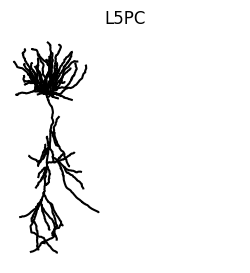

In [4]:
import matplotlib.pyplot as plt

cell.vis()
plt.axis("off")
plt.title("L5PC")
plt.axis("square")
plt.show()

`vis` can be called on any `jx.Module` and every `View` of the module. This means we can also for example use `vis` to highlight each branch. This can be done by iterating over each branch index and calling `cell.branch(i).vis()`. Within the loop.

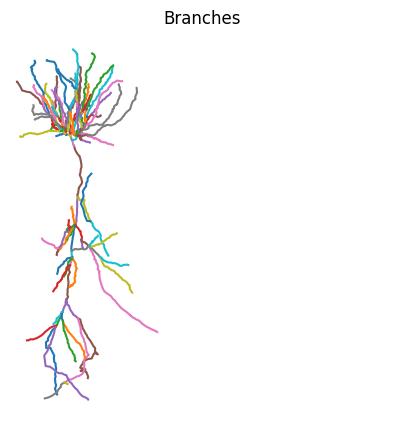

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# define colorwheel with 10 colors
colors = plt.cm.tab10.colors
for i, branch in enumerate(cell.branches):
    branch.vis(ax=ax, color=colors[i % 10])
plt.axis("off")
plt.title("Branches")
plt.axis("square")
plt.show()

While we only use two compartments to approximate each branch in this example, we can see the morphology is still plotted in great detail. This is because we always plot the full `.swc` reconstruction irrespective of the number of compartments used. The morphology lives separately in the `cell.xyzr` attribute in a per branch fashion. 

In addition to plotting the full morphology of the cell using points `vis(type="scatter")` or lines `vis(type="line")`, `Jaxley` also supports plotting a detailed morphological `vis(type="morph")` or approximate compartmental reconstruction `vis(type="comp")` that correctly considers the thickness of the neurite. Note that `"comp"` plots the lengths of each compartment which is equal to the length of the traced neurite. While neurites can be zigzaggy, the compartments that approximate them are straight lines. This can lead to miss-alignment of the compartment ends. For details see the documentation of `vis`. 

The morphologies can either be projected onto 2D or also rendered in 3D. 

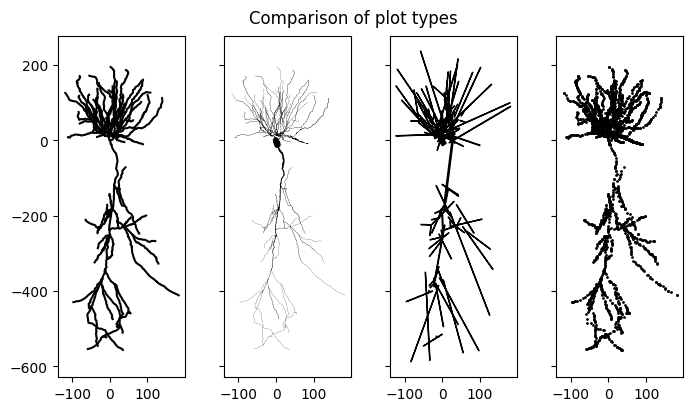

In [6]:
# visualize the cell
fig, ax = plt.subplots(1, 4, figsize=(7, 4), layout="constrained", sharex=True, sharey=True)

cell.vis(ax=ax[0], type="line", dims=[0, 1])  # This is the default.
cell.vis(ax=ax[1], type="morph", dims=[0, 1], linewidth=0.0)
cell.vis(ax=ax[2], type="comp", dims=[0, 1])
cell.vis(ax=ax[3], type="scatter", dims=[0, 1], s=1)

fig.suptitle("Comparison of plot types")
for i in range(4):
    ax[i].set_aspect("equal", adjustable="box")
plt.show()

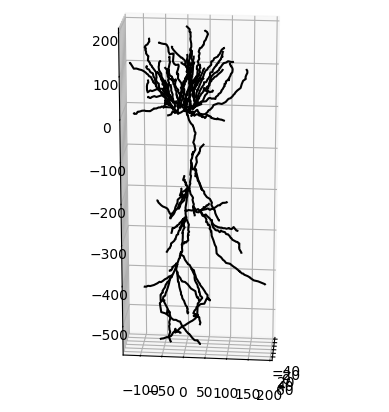

In [7]:
# plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
cell.vis(ax=ax, type="line", dims=[2,0,1])
ax.view_init(elev=20, azim=5)
ax.set_aspect("equal", adjustable="box")
plt.show()

Since `Jaxley` supports grouping different branches or compartments together, we can also use the `id` labels provided by the `.swc` file to assign group labels to the `jx.Cell` object.

['apical', 'basal', 'soma']


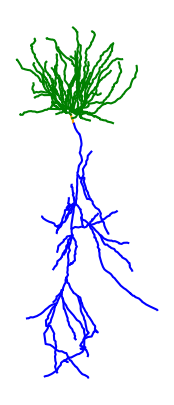

In [8]:
print(cell.group_names)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cell.soma.vis(ax=ax, color="orange")
cell.apical.vis(ax=ax, color="blue")
cell.basal.vis(ax=ax, color="green")
ax.set_aspect("equal")
plt.axis("off")
plt.show()

## Editing morphologies

`Jaxley` provides functionality to edit morphologies. In particular, it provides functions to delete parts of a morphology or to connect two cell morphologies into a single cell.

> **⚠️ IMPORTANT!**  
> If you edit morphologies, please do so _before_ you change the number of compartments per branch (via, e.g., `cell.branch(0).set_ncomp(4)`). In addition, you must delete all recordings, stimuli, and trainable parameters before running `morph_delete()` or `morph_connect()`.

Below, we will show how you can delete all apical branches of a morphology. To do so, we first import the morphology:

In [11]:
import jaxley as jx

fname = "data/morph.swc"
cell = jx.read_swc(fname, ncomp=1)

We then use the `morph_delete` method to delete parts of the morphology:

In [12]:
from jaxley.morphology import morph_delete

# Creates a new cell which has the apical dendrite deleted.
cell = morph_delete(cell.apical)

To check if everything worked, we visualize the resulting morphology (soma highlighted in red):

(-130.92000000000002, 152.44, -21.766, 205.186)

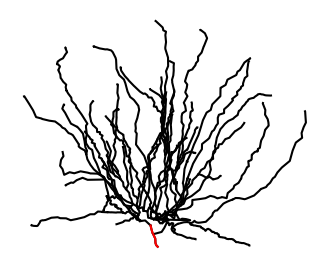

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax = cell.vis(ax=ax)
ax = cell.soma.vis(ax=ax, color="r")
ax.set_aspect("equal")
plt.axis("off")

`Jaxley` also provides functionality to attach two morphologies. This is useful to, for example, replace the axon with a "stub". Below, we show how one can attach two morphologies. To this end, we first create a small "stub" consisting of just a single compartment, which we will attach to the morphology above.

> **⚠️ IMPORTANT!**  
> You must use the same `ncomp` for both morphologies! You can always modify the number of compartments per branch with `cell.branch(0).set_ncomp(n)` afterwards.

In [14]:
# Create a "stub" of 50um length from scratch.
stub = jx.Cell()
stub.set("length", 50.0)
stub.add_to_group("stub")  # Such that we can do `cell.stub` after `morph_connect`.

# Rotate the stub. This is only used for visualization.
stub.compute_xyz()
stub.rotate(90)

Once the two morphologies are defined, we can use `morph_attach` to combine two cells into one:

In [15]:
from jaxley.morphology import morph_connect

new_cell = morph_connect(cell.branch(0).loc(0.0), stub.branch(0).loc(0.0))

Let's visualize the cell before and after having added the stub:

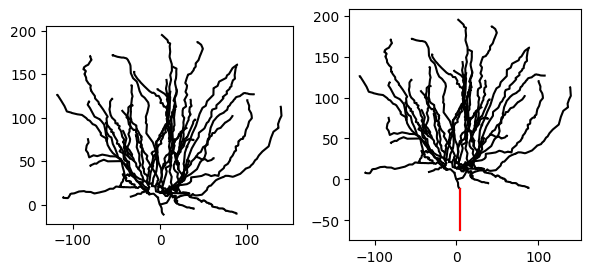

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
_ = cell.vis(ax=ax[0])
_ = new_cell.vis(ax=ax[1])
_ = new_cell.stub.vis(ax=ax[1], color="r")  # .stub only works because we did `add_to_group("stub")` above.
_ = ax[0].set_aspect("equal")
_ = ax[1].set_aspect("equal")

Indeed, the new morphology has an additional stub, which we highlighted in red.

## Assembling cells into a network

To build a network of morphologically detailed cells, we can now connect several reconstructed cells together and also visualize the network. However, since all cells are going to have the same center, `Jaxley` will naively plot all of them on top of each other. To separate out the cells, we therefore have to move them to a new location first.

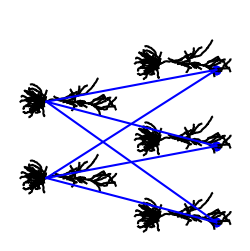

In [17]:
from jaxley.synapses import IonotropicSynapse

fname = "data/morph.swc"
cell = jx.read_swc(fname, ncomp=1)

net = jx.Network([cell]*5)
jx.connect(net.cell(0).soma.branch(0).comp(0), net[2,0,0], IonotropicSynapse())
jx.connect(net.cell(0).soma.branch(0).comp(0), net[3,0,0], IonotropicSynapse())
jx.connect(net.cell(0).soma.branch(0).comp(0), net[4,0,0], IonotropicSynapse())

jx.connect(net.cell(1).soma.branch(0).comp(0), net[2,0,0], IonotropicSynapse())
jx.connect(net.cell(1).soma.branch(0).comp(0), net[3,0,0], IonotropicSynapse())
jx.connect(net.cell(1).soma.branch(0).comp(0), net[4,0,0], IonotropicSynapse())

net.rotate(-90)

net.cell(0).move(0, 900)
net.cell(1).move(0, 1500)

net.cell(2).move(900, 600)
net.cell(3).move(900, 1200)
net.cell(4).move(900, 1800)

net.vis()
plt.axis("off")
plt.axis("square")
plt.show()

Congrats! You have now learned how to visualize and build networks out of very complex morphologies. To simulate this network, you can follow the steps in the tutorial on [how to build a network](https://jaxley.readthedocs.io/en/latest/tutorials/02_small_network.html). If you are a power-user and need more flexibility for editing or inspecting cell morphologies (e.g., trim dendrites), check out the [tutorial on Jaxley's graph backend](https://jaxley.readthedocs.io/en/latest/advanced_tutorials/13_graph_backend.html).